## Предсказание виновника ДТП

Для каршеринговой компании требуется разработать систему, способную предсказать виновника ДТП.

Эта идея находится на стадии предварительного обсуждения и проработки (PoC), и основная цель — оценить возможность предсказания виновности в ДТП на основе исторических данных.

Подход к решению задачи:  
Цель модели — предсказать виновника ДТП (переменная at_fault в таблице parties), где тип виновника — это машина (car).
Ключевые условия:  
Рассматривать только случаи, когда ДТП привели к повреждениям транспортного средства, исключая царапины (тип повреждения — scratch).  
Для обучения модели использовать только данные за 2012 год, так как это самые актуальные данные.  
Обязательно учитывать возраст автомобиля как важный фактор.  
Дополнительная задача — на основе построенной модели провести анализ факторов, влияющих на происшествия, и ответить на следующие вопросы:  

Возможно ли создать надежную систему для оценки рисков водителей при аренде автомобилей?  
Какие другие факторы следует учитывать для более точных предсказаний?  

## Подключитесь к базе. Загрузите таблицы sql

In [1]:
!pip install optuna -q

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from math import ceil
import optuna
import torch
import torch.nn as nn
import lightgbm as lgb
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from scipy import stats
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, roc_curve
from sklearn.metrics import ConfusionMatrixDisplay
import psycopg2
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score

In [3]:
db_config = {
'user': 'praktikum_student', # имя пользователя,
'pwd': 'Sdf4$2;d-d30pp', # пароль,
'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
'port': 6432, # порт подключения,
'db': 'data-science-vehicle-db' # название базы данных,
} 

In [4]:
# Создаем подключение к базе данных
conn = psycopg2.connect(
    user=db_config['user'],
    password=db_config['pwd'],
    host=db_config['host'],
    port=db_config['port'],
    dbname=db_config['db']
)

In [5]:
# Создаем курсор для выполнения запросов
cur = conn.cursor()

In [6]:
# Выполняем SQL запрос, чтобы увидеть список таблиц в базе данных
cur.execute("""SELECT table_name 
            FROM information_schema.tables 
            WHERE table_schema = 'public';""")
tables = cur.fetchall()

In [7]:
# Выводим список таблиц
print("Список таблиц в базе данных:")
for table in tables:
    print(table[0])

Список таблиц в базе данных:
case_ids
collisions
parties
vehicles


Количество и название таблиц в базе данных соответствует заявленным в задании.

## Проведите первичное исследование таблиц

In [8]:
# Для каждой таблицы проверим, есть ли в ней данные
cur = conn.cursor() 

for table in tables:
    table_name = table[0]
    cur.execute(f"SELECT COUNT(*) FROM {table_name};")
    count = cur.fetchone()[0]
    print(f"В таблице {table_name} найдено {count} записей.")



В таблице case_ids найдено 1400000 записей.
В таблице collisions найдено 1400000 записей.
В таблице parties найдено 2752408 записей.
В таблице vehicles найдено 1021234 записей.


In [9]:
cur = conn.cursor()
cur.execute("SELECT * FROM collisions LIMIT 5;")
rows = cur.fetchall()

column_names = [desc[0] for desc in cur.description]

df_coll = pd.DataFrame(rows, columns=column_names)

print(df_coll)



   case_id county_city_location county_location  distance direction  \
0  4083072                 1942     los angeles     528.0     north   
1  4083075                 4313     santa clara       0.0      None   
2  4083073                 0109         alameda       0.0      None   
3  4083077                 0109         alameda       0.0      None   
4  4083087                 4313     santa clara       0.0      None   

   intersection weather_1 location_type collision_damage  party_count  \
0             0    cloudy       highway     small damage            2   
1             1     clear          None     small damage            1   
2             1     clear          None          scratch            2   
3             1     clear          None          scratch            2   
4             1     clear          None          scratch            2   

  primary_collision_factor   pcf_violation_category type_of_collision  \
0   vehicle code violation       unsafe lane change         s

In [10]:
cur = conn.cursor()

cur.execute("SELECT * FROM vehicles LIMIT 5;")
rows = cur.fetchall()

column_names = [desc[0] for desc in cur.description]

df_veh = pd.DataFrame(rows, columns=column_names)

print(df_veh)

        id  case_id  party_number vehicle_type vehicle_transmission  \
0  1175713  5305032             2        sedan               manual   
1        1  3858022             1        sedan                 auto   
2  1175712  5305030             1        sedan                 auto   
3  1175717  5305033             3        sedan                 auto   
4  1175722  5305034             2        sedan                 auto   

   vehicle_age  
0            3  
1            3  
2            3  
3            5  
4            5  


In [11]:
cur = conn.cursor()

cur.execute("SELECT * FROM parties LIMIT 5;")
rows = cur.fetchall()

column_names = [desc[0] for desc in cur.description]

df_part = pd.DataFrame(rows, columns=column_names)

print(df_part)

   id  case_id  party_number   party_type  at_fault  insurance_premium  \
0  22  3899454             1   road signs         1               29.0   
1  23  3899454             2   road signs         0                7.0   
2  29  3899462             2          car         0               21.0   
3  31  3899465             2   road signs         0               24.0   
4  41  3899478             2  road bumper         0                NaN   

          party_sobriety party_drug_physical  cellphone_in_use  
0  had not been drinking                None                 0  
1  had not been drinking                None                 0  
2  had not been drinking                None                 0  
3  had not been drinking                None                 0  
4         not applicable      not applicable                 0  


Все таблицы содержат данные.  
Кол-во таблиц соответствует условию задачи.  
У всех таблиц есть общий ключ - поле case_id.

##  Проведите статистический анализ факторов ДТП

In [12]:
# SQL запрос для проверки полноты данных по годам
# Проверим, чтобы для каждого месяца в каждом году была хотя бы одна авария.

sql_query_0 = """WITH month_counts AS (
    SELECT 
        EXTRACT(YEAR FROM collision_date) AS year,
        EXTRACT(MONTH FROM collision_date) AS month,
        COUNT(*) AS accidents_count
    FROM 
        collisions
    GROUP BY 
        year, month
)
SELECT 
    year, 
    month, 
    accidents_count
FROM 
    month_counts
ORDER BY 
    year, month;"""

df = pd.read_sql_query(sql_query_0, conn)

In [13]:
df.head()

,year,month,accidents_count
0,2009.0,1.0,35062
1,2009.0,2.0,34480
2,2009.0,3.0,36648
3,2009.0,4.0,35239
4,2009.0,5.0,36916


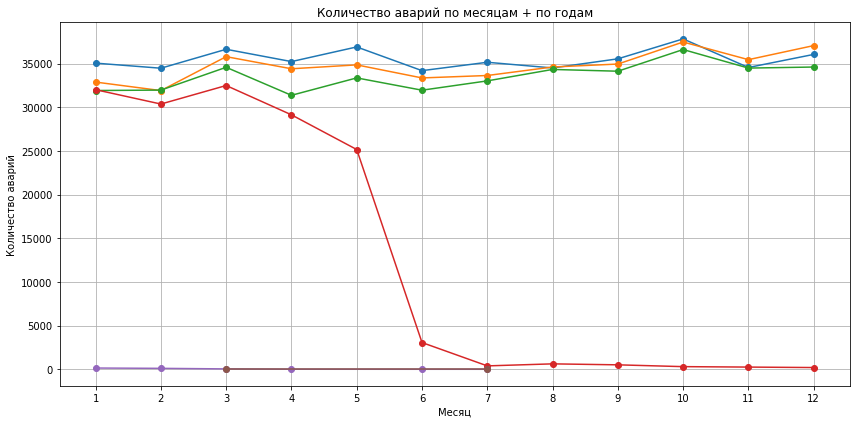

In [14]:
plt.figure(figsize=(12, 6))

for year in df['year'].unique():
    monthly_data = df[df['year'] == year]
    plt.plot(monthly_data['month'], monthly_data['accidents_count'], marker='o', label=f'Год {year}')

plt.title('Количество аварий по месяцам + по годам')
plt.xlabel('Месяц')
plt.ylabel('Количество аварий')
plt.xticks(range(1, 13))
plt.grid(True)
plt.tight_layout()
plt.show()


В данных за 2012 год наблюдается значительное отклонение. До апреля включительно ситуация схожа с предыдущими годами, однако начиная с мая и до июня происходит резкое сокращение количества зарегистрированных ДТП, а затем стабилизируется на очень низком уровне, близком к нулю.

Давайте выведем данные по количеству ДТП за 2012 год с разбивкой по месяцам.

In [15]:
query_month_in_2012 = '''
WITH cbm AS (
SELECT EXTRACT('month' FROM collision_date) AS n_month,
       COUNT(case_id) AS collisions_qty
FROM collisions
WHERE EXTRACT('year' FROM collision_date) = 2012
GROUP BY EXTRACT('month' FROM collision_date)
ORDER BY n_month ASC
)

SELECT to_char(to_timestamp(n_month::text, 'MM'), 'Month') AS month_2012,
       collisions_qty
FROM cbm
'''
df = pd.read_sql_query(query_month_in_2012, conn)

In [16]:
df

,month_2012,collisions_qty
0,January,32020
1,February,30377
2,March,32498
3,April,29143
4,May,25168
5,June,3062
6,July,390
7,August,622
8,September,510
9,October,304


Можно заметить, что количество аварий практически не изменяется по месяцам.

Аналитические задачи

1. Анализ серьёзности повреждений в зависимости от состояния дороги  
Задача: Провести анализ серьёзности повреждений транспортных средств в зависимости от состояния дороги в момент происшествия.
Задача направлена на исследование взаимосвязи между состоянием дороги и степенью повреждения транспортных средств.

2. Определение самых частых причин ДТП  
Задача: Найти наиболее часто встречающиеся причины ДТП, опираясь на категорию нарушения.


3. Влияние погодных условий на серьёзность повреждений
Задача: Проанализировать, как погодные условия влияют на серьёзность повреждений транспортных средств.


4. Влияние времени суток на типы аварий
Задача: Проанализировать, как время суток (день/ночь) влияет на типы аварий.


5. Изучение влияния возраста транспортных средств на тяжесть происшествия
Задача: Оценить, как возраст транспортных средств влияет на серьёзность происшествия.


6. Частота использования мобильных телефонов в авариях


In [17]:
print(df.columns)

Index(['month_2012', 'collisions_qty'], dtype='object')


In [18]:
print(df.isnull().sum())

month_2012        0
collisions_qty    0
dtype: int64


road_condition_1    5
collision_damage    0
accidents_count     0
dtype: int64


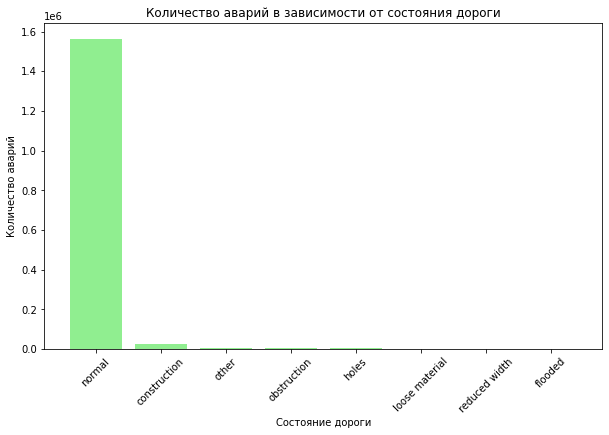

In [19]:
sql_query = """
SELECT 
    c.road_condition_1,
    c.COLLISION_DAMAGE,
    COUNT(*) AS accidents_count
FROM collisions c
JOIN parties p ON c.CASE_ID = p.CASE_ID
GROUP BY c.ROAD_CONDITION_1, c.COLLISION_DAMAGE
ORDER BY accidents_count DESC;
"""

df = pd.read_sql_query(sql_query, conn)

print(df.isnull().sum())  


df = df.dropna(subset=['road_condition_1'])

df['road_condition_1'] = df['road_condition_1'].astype(str)

plt.figure(figsize=(10, 6))
plt.bar(df['road_condition_1'], df['accidents_count'], color='lightgreen')

plt.title('Количество аварий в зависимости от состояния дороги')
plt.xlabel('Состояние дороги')
plt.ylabel('Количество аварий')
plt.xticks(rotation=45)
plt.show()

Подавляющее большинство аварий происходило на дорогах в нормальном состоянии. Лишь незначительная часть на дорогах, которые ремонтировали.

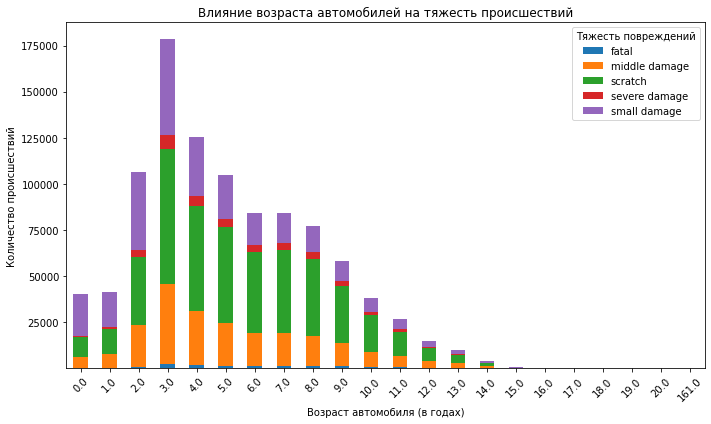

In [20]:
#Анализ аварий по типам происшествий и времени суток

sql_query = """
SELECT 
    v.VEHICLE_AGE,
    c.COLLISION_DAMAGE,
    COUNT(*) AS accidents_count
FROM collisions c
JOIN vehicles v ON c.CASE_ID = v.CASE_ID
GROUP BY v.VEHICLE_AGE, c.COLLISION_DAMAGE
ORDER BY v.VEHICLE_AGE, c.COLLISION_DAMAGE;
"""
df = pd.read_sql_query(sql_query, conn)


pivot_df = df.pivot_table(index='vehicle_age', columns='collision_damage', values='accidents_count', aggfunc='sum', fill_value=0)

pivot_df.plot(kind='bar', stacked=True, figsize=(10, 6))

plt.title('Влияние возраста автомобилей на тяжесть происшествий')
plt.xlabel('Возраст автомобиля (в годах)')
plt.ylabel('Количество происшествий')
plt.xticks(rotation=45)
plt.legend(title='Тяжесть повреждений')
plt.tight_layout()
plt.show()


Большинство аварий произошло на автомобилях, которым 3 года, 4, 5 и 2.  
Причинами может быть:   
- Экономия на обслуживании: Владелец может начать экономить на регулярном техническом обслуживании, что повышает вероятность технических сбоев.

- Активное использование: Машины возрастом 2–5 лет часто находятся в фазе максимальной эксплуатации. Они могут быть основным транспортом для семьи или бизнеса.  

- Первая смена владельца: Автомобили этого возраста часто перепродаются. Новые владельцы могут использовать их интенсивнее, либо не знать о реальном состоянии автомобиля.  

- Неосторожное вождение: Водители часто более уверенно ведут автомобиль спустя 1–2 года после покупки, что может приводить к повышенной агрессивности или самоуверенности.

- Популярность этого возраста: Автомобили возрастом 2–5 лет составляют значительную долю на дорогах, так как они ещё относительно новые и доступны по цене. Чем больше таких машин, тем выше вероятность их участия в авариях.

## Создайте модель для оценки водительского риска

Первичный отбор признаков, необходимых для модели

In [21]:
sql_query_3 = """SELECT
    c.county_city_location,
    c.distance,
    c.direction,
    c.weather_1,
    c.location_type,
    c.road_surface,
    c.road_condition_1,
    c.lighting,
    c.control_device,
    p.party_type,
    p.at_fault,
    p.insurance_premium,
    p.party_sobriety,
    p.party_drug_physical,
    p.cellphone_in_use,
    v.vehicle_transmission,
    v.vehicle_age,
    v.vehicle_type,
    c.intersection
FROM collisions AS c
JOIN parties AS p ON c.case_id = p.case_id
JOIN vehicles AS v ON c.case_id = v.case_id AND p.party_number = v.party_number
WHERE EXTRACT('year' FROM c.collision_date) = 2012
  AND v.vehicle_age IS NOT NULL
  AND p.party_type = 'car'
  AND c.collision_damage NOT IN ('scratch')
"""

df_primery = pd.read_sql_query(sql_query_3, conn)

df_primery.head()


,county_city_location,distance,direction,weather_1,location_type,road_surface,road_condition_1,lighting,control_device,party_type,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use,vehicle_transmission,vehicle_age,vehicle_type,intersection
0,1942,20.0,south,clear,None,dry,normal,daylight,functioning,car,0,46.0,had not been drinking,None,0.0,auto,2,sedan,0.0
1,4100,40.0,east,clear,intersection,dry,other,dark with no street lights,none,car,1,38.0,"had been drinking, under influence",None,0.0,auto,5,sedan,0.0
2,3607,400.0,north,clear,None,dry,normal,dark with street lights,none,car,1,43.0,had not been drinking,None,0.0,auto,8,sedan,0.0
3,2908,190.0,east,clear,None,dry,normal,dark with no street lights,none,car,1,38.0,"had been drinking, under influence",None,0.0,auto,6,sedan,0.0
4,1600,2640.0,east,cloudy,highway,wet,normal,daylight,none,car,1,20.0,had not been drinking,None,0.0,auto,11,sedan,0.0


На данном этапе я сделала запрос и ставила таблицу из всех признаков, которые были известны до момента аварии.

In [22]:
df_primery.describe()

,distance,at_fault,insurance_premium,cellphone_in_use,vehicle_age,intersection
count,5.455400e+04,54554.000000,54135.000000,50384.000000,54554.000000,54386.000000
mean,8.761480e+02,0.504839,37.627025,0.020245,4.856472,0.218659
std,7.348699e+03,0.499981,16.349592,0.140837,3.234503,0.413341
min,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,9.000000e+00,0.000000,24.000000,0.000000,3.000000,0.000000
50%,1.430000e+02,1.000000,34.000000,0.000000,4.000000,0.000000
75%,5.757500e+02,1.000000,49.000000,0.000000,7.000000,0.000000
max,1.584000e+06,1.000000,105.000000,1.000000,161.000000,1.000000


In [23]:
df_primery.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54554 entries, 0 to 54553
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   county_city_location  54554 non-null  object 
 1   distance              54554 non-null  float64
 2   direction             42097 non-null  object 
 3   weather_1             54389 non-null  object 
 4   location_type         25511 non-null  object 
 5   road_surface          54225 non-null  object 
 6   road_condition_1      54317 non-null  object 
 7   lighting              54402 non-null  object 
 8   control_device        54348 non-null  object 
 9   party_type            54554 non-null  object 
 10  at_fault              54554 non-null  int64  
 11  insurance_premium     54135 non-null  float64
 12  party_sobriety        53718 non-null  object 
 13  party_drug_physical   2686 non-null   object 
 14  cellphone_in_use      50384 non-null  float64
 15  vehicle_transmissio

In [24]:
df_primery.isna().sum()

county_city_location        0
distance                    0
direction               12457
weather_1                 165
location_type           29043
road_surface              329
road_condition_1          237
lighting                  152
control_device            206
party_type                  0
at_fault                    0
insurance_premium         419
party_sobriety            836
party_drug_physical     51868
cellphone_in_use         4170
vehicle_transmission      575
vehicle_age                 0
vehicle_type                0
intersection              168
dtype: int64

In [25]:
for item in df_primery.columns:
    try:
        df_primery[item] = df_primery[item].str.lower()
    except:
        pass

In [26]:
df_primery.duplicated().sum()

375

## Проведите анализ важности факторов ДТП

In [27]:
correlation = df_primery['at_fault'].corr(df_primery['distance'])
correlation

0.032351433703880404

Correlation близка к 0, это может свидетельствовать о слабой связи. Не буду использовать этот признак.

In [28]:
def values_distribution(col_to_cross_name, ax):
     
    (pd.crosstab(df_primery[col_to_cross_name], df_primery['at_fault'], margins=True)
    .drop('All', axis=0)
    .assign(norm_0 = lambda x: x[0]/x['All'])
    .assign(norm_1 = lambda x: x[1]/x['All'])[['norm_0', 'norm_1']]
    .rename(columns={'norm_0':'0', 'norm_1':'1'})
    .sort_values(by='0')
    .plot(kind='bar', ax=ax, stacked=True))



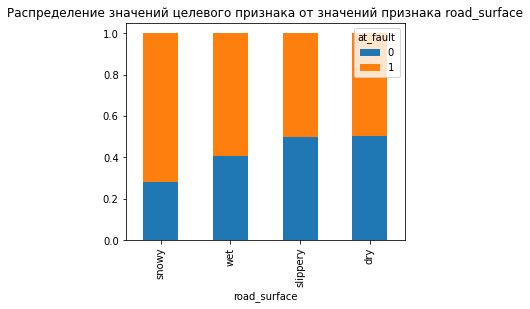

In [29]:
fig, ax = plt.subplots(figsize=(5, 4))
values_distribution('road_surface', ax)
ax.set_title(
    'Распределение значений целевого признака от значений признака road_surface',
    fontsize=12
)
plt.show()

Целевой признак изменяется в зависимости от значений признака road_surface. Оставляем

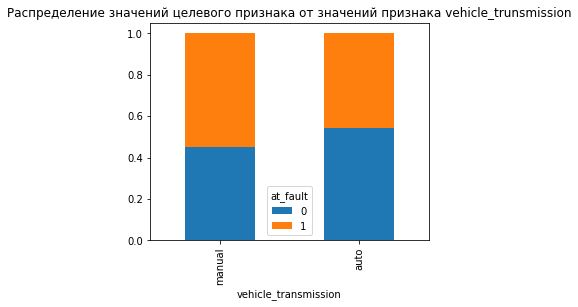

In [30]:
fig, ax = plt.subplots(figsize=(5, 4))
values_distribution('vehicle_transmission', ax)
ax.set_title(
    'Распределение значений целевого признака от значений признака vehicle_trunsmission',
    fontsize=12
)
plt.show()

Целевой признак изменяется в зависимости от значений признака vehicle_transmission. Оставляем

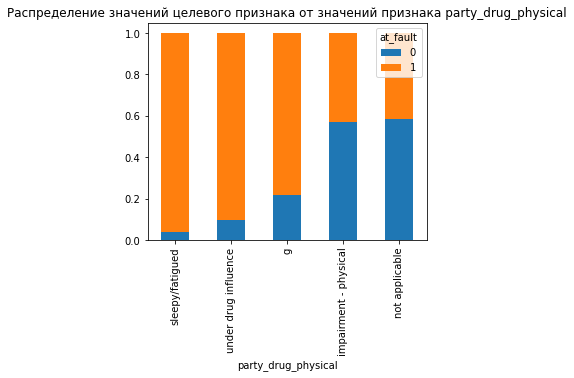

In [31]:
fig, ax = plt.subplots(figsize=(5, 4))
values_distribution('party_drug_physical', ax)
ax.set_title(
    'Распределение значений целевого признака от значений признака party_drug_physical',
    fontsize=12
)
plt.show()

Целевой признак изменяется в зависимости от значений признака party_drug_physical. Но слишком много пропусков

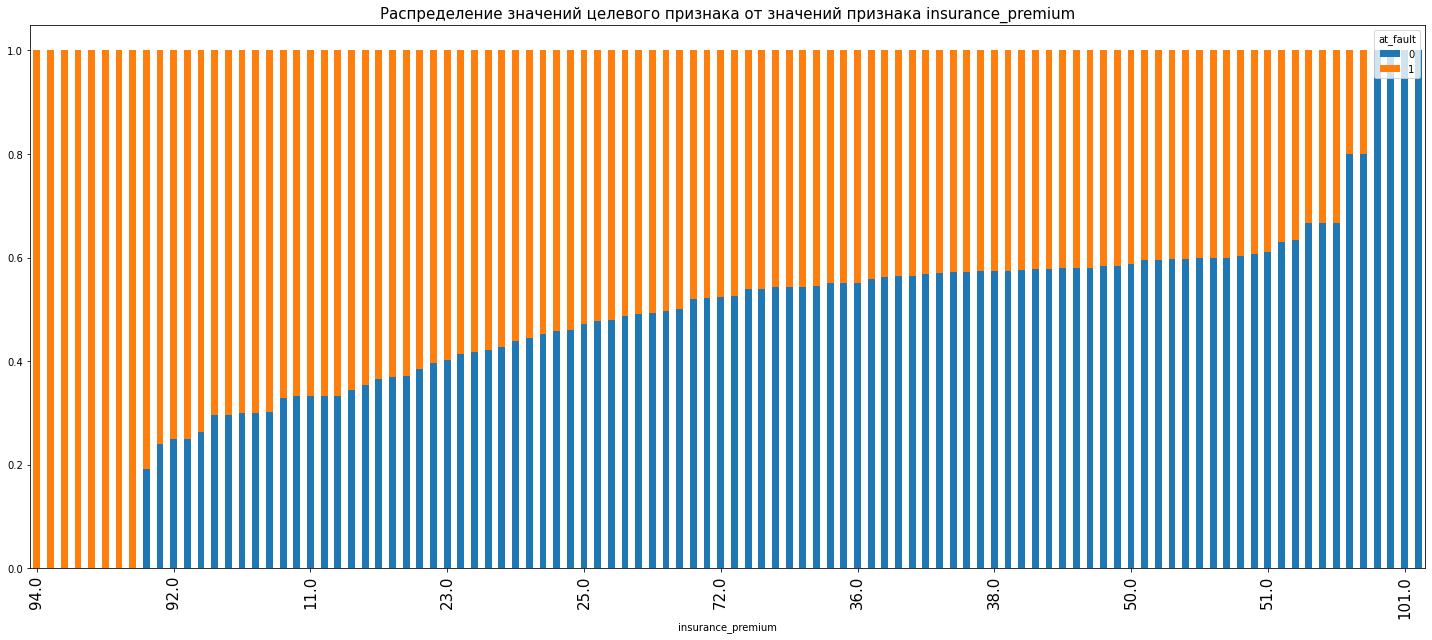

In [32]:
fig, ax = plt.subplots(figsize=(25, 10))
values_distribution('insurance_premium', ax)
xticks = ax.get_xticks()
plt.xticks(xticks[::10], rotation=90, ha='center',fontsize=15)
ax.set_title(
    'Распределение значений целевого признака от значений признака insurance_premium',
    fontsize=15
)
plt.show()

Целевой признак изменяется в зависимости от значений признака insurance_premium. Оставляем

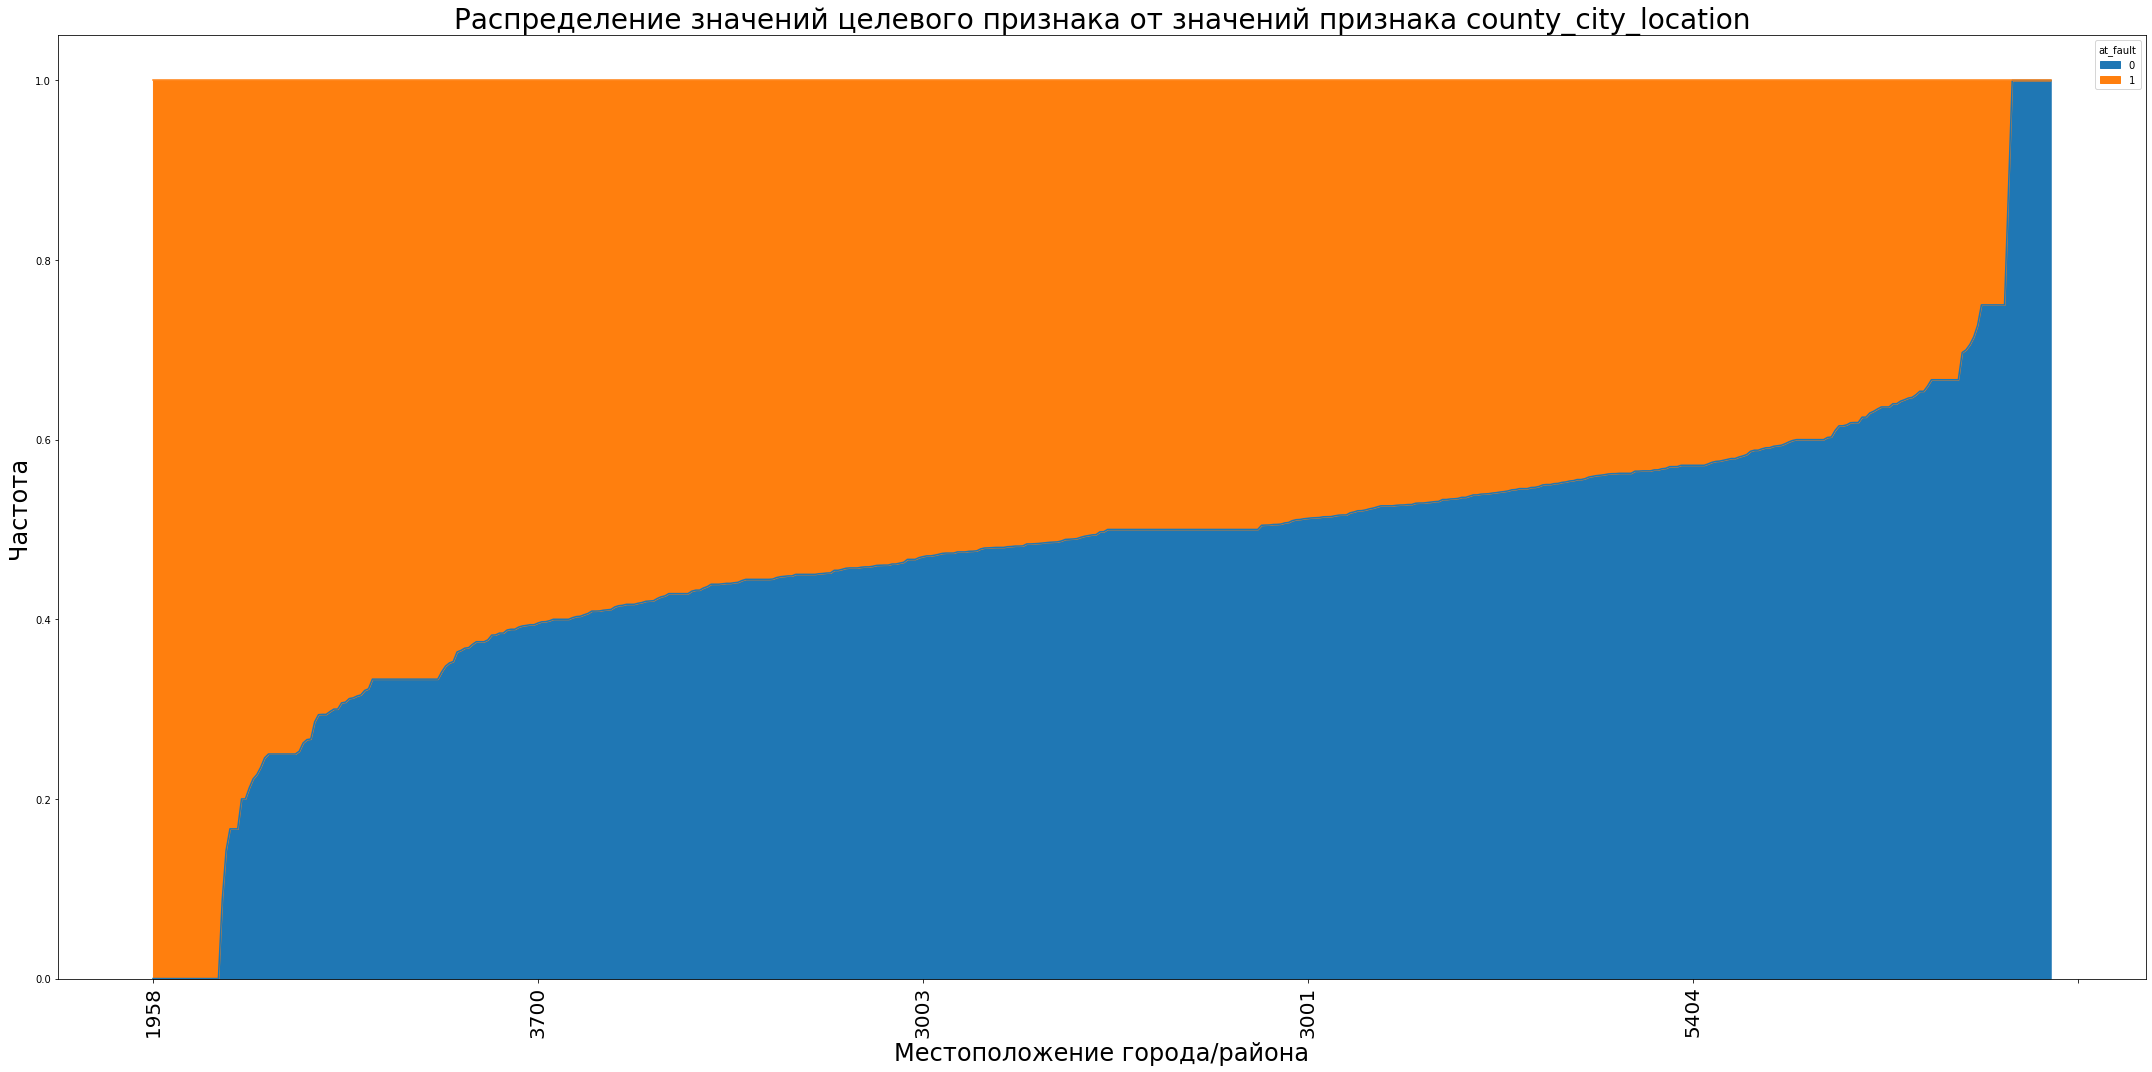

In [33]:
def values_d(col_to_cross_name, ax):
    (pd.crosstab(df_primery[col_to_cross_name], df_primery['at_fault'], margins=True)
     .drop('All', axis=0)
     .assign(norm_0 = lambda x: x[0]/x['All'])
     .assign(norm_1 = lambda x: x[1]/x['All'])[['norm_0', 'norm_1']]
     .rename(columns={'norm_0': '0', 'norm_1': '1'})
     .sort_values(by='0')
     .plot(kind='area', ax=ax, stacked=True))

fig, ax = plt.subplots(figsize=(30, 15))
values_d('county_city_location', ax)
xticks = ax.get_xticks()
plt.xticks(rotation=90, ha='center', fontsize=20)
ax.set_title('Распределение значений целевого признака от значений признака county_city_location', fontsize=28)
ax.set_xlabel('Местоположение города/района', fontsize=24)
ax.set_ylabel('Частота', fontsize=24)
plt.tight_layout()
plt.show()



Целевой признак изменяется в зависимости от значений признака county_city_location. Оставляем

Для построения модели оценки водительского риска важно провести первичный отбор факторов, которые могут повлиять на вероятность ДТП. Из имеющихся столбцов в DataFrame выделим те, которые могут существенно повлиять на тяжесть и вероятность происшествий.

1. at_fault (Виновность)
Описание: Этот столбец указывает на то, кто является виновным в происшествии.
Почему важен: Это ключевой фактор, так как виновность напрямую влияет на вероятность происшествия. Например, если водитель не соблюдает правила, вероятность аварий растет.
2. vehicle_age (Возраст автомобиля)
Описание: Возраст транспортного средства.
Почему важен: Старые автомобили могут иметь повышенный риск аварий из-за изношенности компонентов или устаревших технологий. Это фактор, который имеет значительный эффект на безопасность транспортного средства.
3. vehicle_type (Тип транспортного средства)
Описание: Тип транспортного средства (например, легковой автомобиль, грузовик и т. д.).
Почему важен: Тип транспортного средства влияет на его поведение на дороге. Например, крупные автомобили, такие как грузовики, могут быть более склонны к тяжелым последствиям при авариях, а легковые автомобили чаще попадают в ДТП.
4. weather_1 (Погодные условия)
Описание: Погодные условия во время происшествия.
Почему важен: Погодные условия играют важную роль в безопасности на дороге. Например, дождь, снег или туман могут сильно повлиять на видимость и сцепление с дорогой, что повышает вероятность аварии.
5. road_condition_1 (Состояние дороги)
Описание: Состояние дорожного покрытия (например, мокрое, сухое, с ямами и т. д.).
Почему важен: Плохое состояние дороги может стать причиной ДТП, особенно если на дороге есть ямы, скользкие участки или ограниченная видимость.
6. lighting (Освещенность)
Описание: Уровень освещенности на месте происшествия.
Почему важен: Недостаточная освещенность может привести к снижению видимости и увеличить вероятность ДТП, особенно в ночное время.
7. cellphone_in_use (Использование мобильного телефона)
Описание: Использование мобильного телефона водителем во время происшествия.
Почему важен: Использование мобильного телефона снижает внимание водителя, что является одной из ведущих причин ДТП.
8. party_sobriety (Трезвость водителя)
Описание: Состояние трезвости водителя.
Почему важен: Водитель в нетрезвом состоянии значительно увеличивает вероятность ДТП, так как нарушаются координация, реакция и внимание.
9. intersection
10. insurance_premium (Страховая премия)
Описание: Страховая премия, возможно, связан с типом покрытия страховки.
Почему важен: В некоторых случаях высокие страховые премии могут указывать на высокие риски и на более частые аварии.
11. control_device (Устройство управления)
Описание: Использование устройства управления для регулирования движения.
Почему важен: Несправности в системе управления транспортным средством (например, тормоза) могут повысить вероятность аварии.
12. road_surface
13. vehicle_transmission


In [34]:
df_primery = df_primery.rename(columns={'weather_1':'weather',
                                'road_condition_1':'road_condition'})

In [35]:
columns =['at_fault', 'vehicle_age', 'vehicle_type', 'weather', 'road_condition', 'lighting', 'cellphone_in_use',
          'party_sobriety', 'intersection', 'insurance_premium', 'control_device','road_surface','vehicle_transmission'] 

In [36]:
data = df_primery[columns].copy()

In [37]:
data.head()

,at_fault,vehicle_age,vehicle_type,weather,road_condition,lighting,cellphone_in_use,party_sobriety,intersection,insurance_premium,control_device,road_surface,vehicle_transmission
0,0,2,sedan,clear,normal,daylight,0.0,had not been drinking,0.0,46.0,functioning,dry,auto
1,1,5,sedan,clear,other,dark with no street lights,0.0,"had been drinking, under influence",0.0,38.0,none,dry,auto
2,1,8,sedan,clear,normal,dark with street lights,0.0,had not been drinking,0.0,43.0,none,dry,auto
3,1,6,sedan,clear,normal,dark with no street lights,0.0,"had been drinking, under influence",0.0,38.0,none,dry,auto
4,1,11,sedan,cloudy,normal,daylight,0.0,had not been drinking,0.0,20.0,none,wet,auto


In [38]:
data.shape

(54554, 13)

In [39]:
data.duplicated().sum()

25312

In [40]:
data = data.drop_duplicates()

In [41]:
data.isna().sum()

at_fault                   0
vehicle_age                0
vehicle_type               0
weather                  163
road_condition           237
lighting                 152
cellphone_in_use        3673
party_sobriety           769
intersection             166
insurance_premium        348
control_device           206
road_surface             329
vehicle_transmission     554
dtype: int64

In [42]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29242 entries, 0 to 54553
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   at_fault              29242 non-null  int64  
 1   vehicle_age           29242 non-null  int64  
 2   vehicle_type          29242 non-null  object 
 3   weather               29079 non-null  object 
 4   road_condition        29005 non-null  object 
 5   lighting              29090 non-null  object 
 6   cellphone_in_use      25569 non-null  float64
 7   party_sobriety        28473 non-null  object 
 8   intersection          29076 non-null  float64
 9   insurance_premium     28894 non-null  float64
 10  control_device        29036 non-null  object 
 11  road_surface          28913 non-null  object 
 12  vehicle_transmission  28688 non-null  object 
dtypes: float64(3), int64(2), object(8)
memory usage: 3.1+ MB


In [43]:
data['vehicle_age'].fillna(data['vehicle_age'].median(), inplace=True)
data['insurance_premium'].fillna(data['insurance_premium'].median(), inplace=True)

categorical_cols = ['vehicle_type', 'weather', 'road_condition', 
                   'lighting', 'cellphone_in_use', 'intersection', 'control_device', 'road_surface', 
                   'vehicle_transmission','party_sobriety']
for col in categorical_cols:
    data[col].fillna(data[col].mode()[0], inplace=True)

for col in categorical_cols:
    data[col] = data[col].astype('category')

In [44]:
data = data.dropna()
data.shape

(29242, 13)

In [45]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29242 entries, 0 to 54553
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   at_fault              29242 non-null  int64   
 1   vehicle_age           29242 non-null  int64   
 2   vehicle_type          29242 non-null  category
 3   weather               29242 non-null  category
 4   road_condition        29242 non-null  category
 5   lighting              29242 non-null  category
 6   cellphone_in_use      29242 non-null  category
 7   party_sobriety        29242 non-null  category
 8   intersection          29242 non-null  category
 9   insurance_premium     29242 non-null  float64 
 10  control_device        29242 non-null  category
 11  road_surface          29242 non-null  category
 12  vehicle_transmission  29242 non-null  category
dtypes: category(10), float64(1), int64(2)
memory usage: 1.2 MB


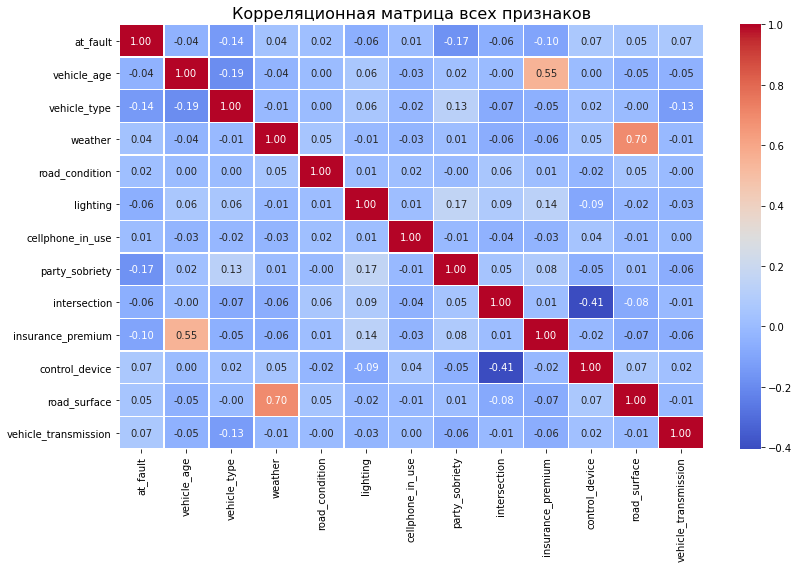

In [46]:
data_1 = data.copy()
categorical_columns = data_1.columns[data_1.dtypes == 'category']
encoder = LabelEncoder()

for col in categorical_columns:
    data_1[col] = encoder.fit_transform(data_1[col])


correlation_matrix = data_1.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Корреляционная матрица всех признаков', fontsize=16)
plt.tight_layout()
plt.show()


Мы наблюдаем достаточно сильную корреляцию между признаками возраста автомобиля и стоимости страховки. Это вполне логично: с возрастом автомобиля страховка, как правило, становится выше. Старые машины чаще требуют ремонта, требуют большего ухода и могут чаще выходить из строя.

Также заметна сильная связь между состоянием дорожной поверхности и погодными условиями. Это тоже объяснимо: именно погода определяет, будет ли дорога сухой, мокрой, скользкой или покрытой льдом, что напрямую влияет на ее характеристики.

Вывод. На данном этапе нами была разработана модель для оценки водительского риска. Сначала мы исключили все признаки, непосредственно описывающие ДТП, чтобы избежать их влияния на результаты. Затем провели анализ важности факторов, связанных с аварийностью, и отобрали из исходной таблицы 13 наиболее значимых признаков, включая целевой, которые будут использоваться для обучения моделей.

## Обучение моделей 

In [47]:
X = data.drop('at_fault', axis=1)
y = data['at_fault']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

In [48]:
print(X_train.shape, X_test.shape)

(21931, 12) (7311, 12)


In [49]:
columns_numeric = ['vehicle_age', 'insurance_premium']

columns_category = ['vehicle_type', 'weather', 'road_condition', 
                   'lighting', 'cellphone_in_use', 'intersection', 'control_device', 'road_surface', 
                   'vehicle_transmission','party_sobriety']

/opt/conda/lib/python3.9/site-packages/pandas/io/formats/format.py:1405: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())
/opt/conda/lib/python3.9/site-packages/pandas/io/formats/format.py:1405: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())


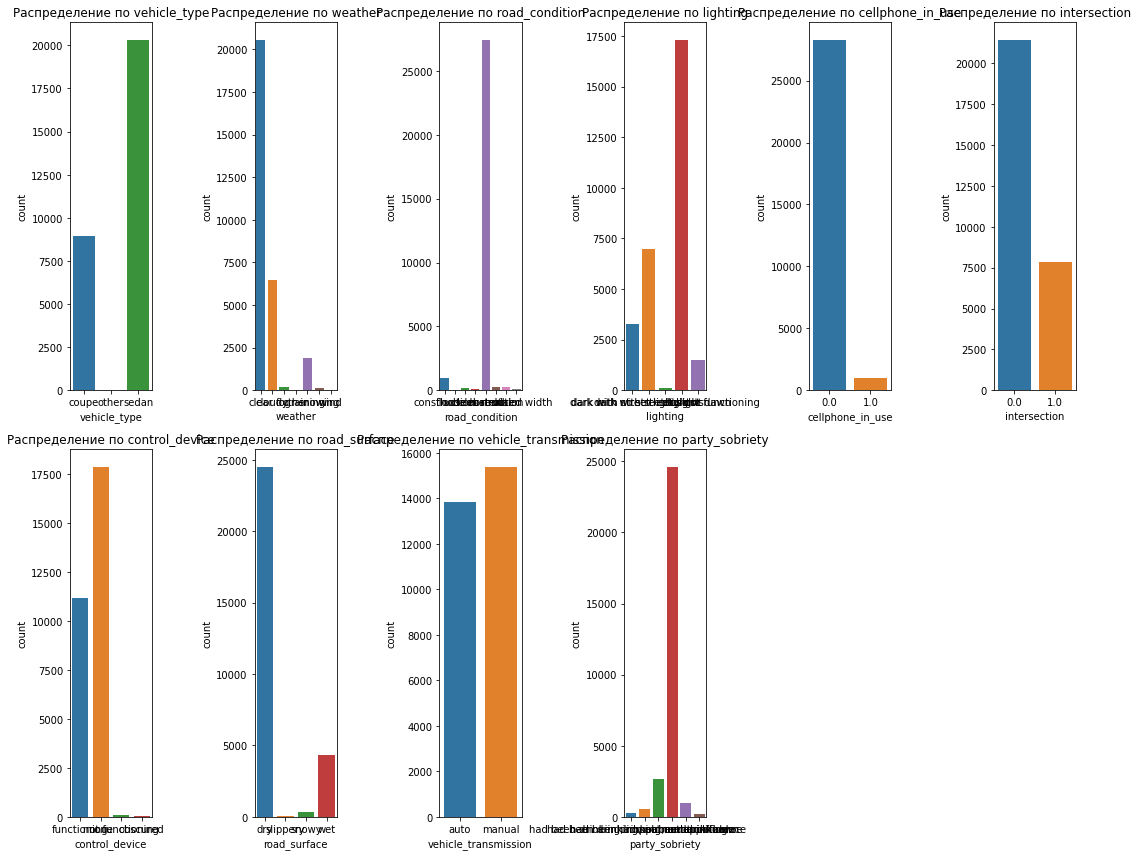

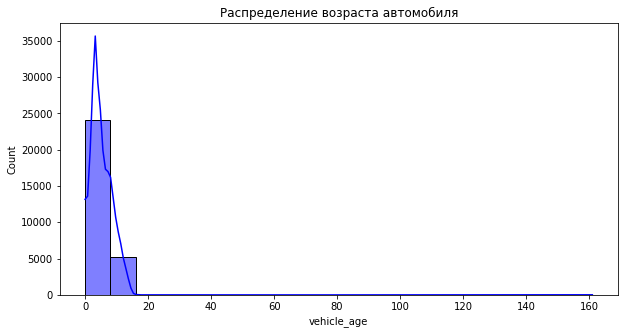

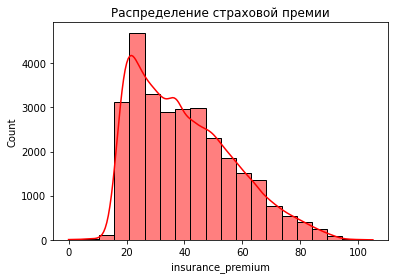

KeyError: 'party_number'

In [51]:
plt.figure(figsize=(15, 12))
for i, col in enumerate(categorical_cols):
    plt.subplot(2, 6, i+1)
    sns.countplot(x=data[col])
    plt.title(f'Распределение по {col}')
plt.tight_layout()
plt.show()


plt.figure(figsize=(10, 5))
sns.histplot(data['vehicle_age'], kde=True, color='blue', bins=20)
plt.title('Распределение возраста автомобиля')
plt.show()

sns.histplot(data['insurance_premium'], kde=True, color='red', bins=20)
plt.title('Распределение страховой премии')
plt.show()

sns.histplot(data['party_number'], kde=True, color='red', bins=20)
plt.title('Распределение количества участников')
plt.show()

correlation_matrix = data[['vehicle_age', 'insurance_premium']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', cbar=True)
plt.title('Корреляция между возрастом автомобиля и страховой премией')
plt.show()

In [52]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29242 entries, 0 to 54553
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   at_fault              29242 non-null  int64   
 1   vehicle_age           29242 non-null  int64   
 2   vehicle_type          29242 non-null  category
 3   weather               29242 non-null  category
 4   road_condition        29242 non-null  category
 5   lighting              29242 non-null  category
 6   cellphone_in_use      29242 non-null  category
 7   party_sobriety        29242 non-null  category
 8   intersection          29242 non-null  category
 9   insurance_premium     29242 non-null  float64 
 10  control_device        29242 non-null  category
 11  road_surface          29242 non-null  category
 12  vehicle_transmission  29242 non-null  category
dtypes: category(10), float64(1), int64(2)
memory usage: 2.2 MB


Данные для модели подготовлены.

Датасет содержит 29242 записей в 13 столбцах (12 признаков, 1 целевой), пропусков нет, дубликатов нет.
Типы данных: category(10), float64(1), int64(2)
Размер 2.2 MB

Выбор метрики для оценки модели:   
  
В данном случае, задача состоит в классификации, и важно выбрать метрику, которая подходит для оценок риска. Поскольку в бизнес-задаче может быть критически важно минимизировать количество ложных отрицательных срабатываний (то есть ДТП с высоким риском, которые не были классифицированы как таковые), лучшей метрикой будет F1-мерка, которая является средним гармоническим точности и полноты.  

Преобразуем категориальные переменные в числовой формат с использованием one-hot encoding.  

Модели для использования:
Логистическая регрессия.  
Случайный лес.  
Градиентный бустинг (XGBoost).  


In [53]:
categorical_cols = ['vehicle_type', 'weather', 'road_condition', 
                   'lighting', 'cellphone_in_use', 'intersection', 'control_device', 'road_surface', 
                   'vehicle_transmission','party_sobriety']


log_reg = Pipeline([
    ('preprocessor', ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(drop='first'), categorical_cols),
            ('num', StandardScaler(), X.columns.difference(categorical_cols))])),
    ('classifier', LogisticRegression(solver='liblinear', max_iter=5000, class_weight='balanced'))
])

log_reg_params = {'classifier__C': [0.1, 1, 10], 'classifier__penalty': ['l2']}
log_reg_search = GridSearchCV(log_reg, log_reg_params, cv=5, scoring='f1', n_jobs=-1)

# Случайный лес
rf = Pipeline([
    ('preprocessor', ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(drop='first'), categorical_cols),
            ('num', 'passthrough', X.columns.difference(categorical_cols))])),
    ('classifier', RandomForestClassifier(random_state=42))
])

rf_params = {
    'classifier__n_estimators': [50, 100],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5]
}
rf_search = GridSearchCV(rf, rf_params, cv=5, scoring='f1', n_jobs=-1)

# XGBoost
xgb = Pipeline([
    ('preprocessor', ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(drop='first'), categorical_cols),
            ('num', 'passthrough', X.columns.difference(categorical_cols))])),
    ('classifier', XGBClassifier(random_state=42, eval_metric='mlogloss'))
])

xgb_params = {
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__n_estimators': [50, 100],
    'classifier__max_depth': [3, 6]
}
xgb_search = GridSearchCV(xgb, xgb_params, cv=5, scoring='f1', n_jobs=-1)



In [54]:
log_reg_search.fit(X_train, y_train)
rf_search.fit(X_train, y_train)
xgb_search.fit(X_train, y_train)

print("Лучшие результаты для Logistic Regression:")
print(f"Лучшие гиперпараметры: {log_reg_search.best_params_}")
print(f"Лучшая метрика: {log_reg_search.best_score_}\n")

print("Лучшие результаты для Random Forest:")
print(f"Лучшие гиперпараметры: {rf_search.best_params_}")
print(f"Лучшая метрика: {rf_search.best_score_}\n")

print("Лучшие результаты для XGBoost:")
print(f"Лучшие гиперпараметры: {xgb_search.best_params_}")
print(f"Лучшая метрика: {xgb_search.best_score_}\n")

/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encode

Лучшие результаты для Logistic Regression:
Лучшие гиперпараметры: {'classifier__C': 0.1, 'classifier__penalty': 'l2'}
Лучшая метрика (accuracy или другая): 0.5483461975216538

Лучшие результаты для Random Forest:
Лучшие гиперпараметры: {'classifier__max_depth': 10, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 50}
Лучшая метрика (accuracy или другая): 0.6025282919132171

Лучшие результаты для XGBoost:
Лучшие гиперпараметры: {'classifier__learning_rate': 0.01, 'classifier__max_depth': 3, 'classifier__n_estimators': 50}
Лучшая метрика (accuracy или другая): 0.6264898666153151



In [60]:
results = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'XGBoost'],
    'Best Params': [log_reg_search.best_params_, rf_search.best_params_, xgb_search.best_params_],
    'F1 Score': [log_reg_search.best_score_, rf_search.best_score_, xgb_search.best_score_]
})

# Оформление таблицы с использованием стилей
styled_results = results.style.set_table_styles([
    {'selector': 'thead th', 'props': [('background-color', '#4CAF50'), ('color', 'white'), ('font-weight', 'bold'), ('text-align', 'center')]},
    {'selector': 'tbody td', 'props': [('text-align', 'center'), ('font-size', '12px')]},
    {'selector': 'tr:nth-child(odd)', 'props': [('background-color', '#f9f9f9')]},
    {'selector': 'tr:nth-child(even)', 'props': [('background-color', '#f1f1f1')]},
    {'selector': 'td', 'props': [('padding', '10px'), ('border', '1px solid #ddd')]},
    {'selector': 'table', 'props': [('border-collapse', 'collapse'), ('width', '100%')]},
    {'selector': '.col0', 'props': [('max-width', '200px')]},  # Ограничение ширины столбца с моделью
    {'selector': '.col1', 'props': [('white-space', 'pre-wrap'), ('word-wrap', 'break-word')]},  # Перенос длинных параметров
])

# Отображение таблицы с применением стилей
styled_results


,Model,Best Params,F1 Score
0,Logistic Regression,"{'classifier__C': 0.1, 'classifier__penalty': 'l2'}",0.548346
1,Random Forest,"{'classifier__max_depth': 10, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 50}",0.602528
2,XGBoost,"{'classifier__learning_rate': 0.01, 'classifier__max_depth': 3, 'classifier__n_estimators': 50}",0.626490


In [61]:
best_xgb_model = xgb_search.best_estimator_
# Предсказания на тестовой выборке
xgb_preds = best_xgb_model.predict(X_test)

# F1-метрика на тестовой выборке
xgb_f1_test = f1_score(y_test, xgb_preds)

print(f"XGBoost F1 score: {xgb_f1_test}")

XGBoost F1 score: 0.6271551724137931


XGBoost достиг F1 Score = 0.6271551724137931, что является наилучшим результатом среди всех моделей. 

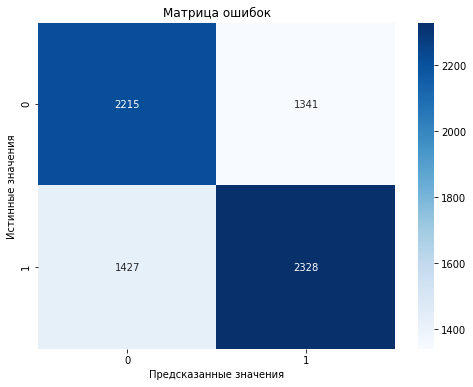

In [64]:
# Построение Матрицы ошибок
cm = confusion_matrix(y_test, xgb_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel('Предсказанные значения')
plt.ylabel('Истинные значения')
plt.title('Матрица ошибок')
plt.show()

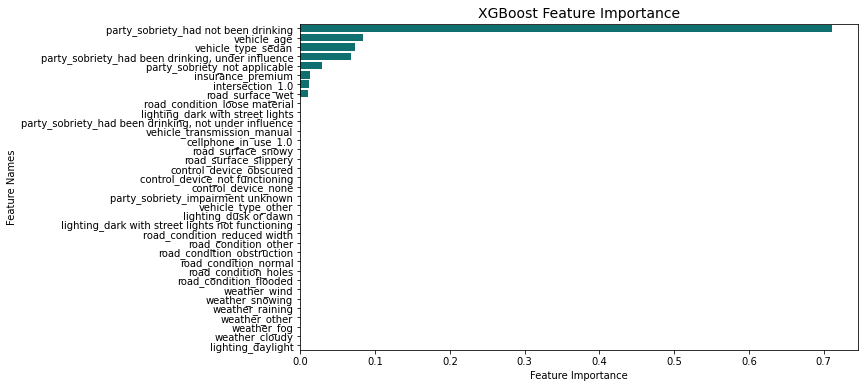

In [70]:
def plot_feature_importance(importance, fch_names, model_type):
    feature_importance = np.array(importance)
    feature_names = np.array(fch_names)
    
    data = {'feature_names': feature_names, 'feature_importance': feature_importance}
    fch_df = pd.DataFrame(data)   
    fch_df.sort_values(by=['feature_importance'], ascending=False, inplace=True)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x=fch_df['feature_importance'], y=fch_df['feature_names'], color='teal')
    
    plt.title(f'{model_type} Feature Importance', fontsize=14)
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')
    plt.show()

xgb_best_model = xgb_search.best_estimator_

preprocessor = xgb_best_model.named_steps['preprocessor']
encoder = preprocessor.transformers_[0][1]  

encoder.fit(X_train[categorical_cols])  
encoded_columns = encoder.get_feature_names(categorical_cols) 

numeric_columns = X_train.select_dtypes(include=['number']).columns
all_feature_names = np.concatenate([encoded_columns, numeric_columns])
feature_importance = xgb_best_model.named_steps['classifier'].feature_importances_

# Проверяем, что длина массивов одинаковая
assert len(all_feature_names) == len(feature_importance), "Длины массивов не совпадают!"

# Объединяем имена признаков с их важностями
plot_feature_importance(feature_importance, all_feature_names, 'XGBoost')


Исследование зависимости между party_sobriety и целевой переменной (виновность в ДТП)  

Как показано в выводах анализа важности признаков, фактор party_sobriety оказывает значительное влияние на вероятность ДТП. Для дальнейшего анализа давайте построим график зависимости между party_sobriety и целевой переменной (например, с использованием бинарной целевой переменной, где 1 — это виновность в ДТП, а 0 — нет).

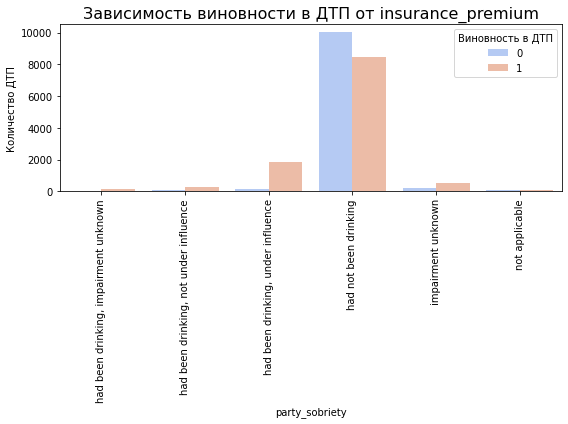

In [73]:
plt.figure(figsize=(8, 6))
sns.countplot(data=X_train, x='party_sobriety', hue=y_train, palette='coolwarm')
plt.title('Зависимость виновности в ДТП от insurance_premium', fontsize=16)
plt.xlabel('party_sobriety')
plt.ylabel('Количество ДТП')
plt.legend(title='Виновность в ДТП')
plt.xticks(rotation=90, ha='center')
plt.tight_layout()
plt.show()


Рекомендации по оборудованию автомобиля для учета фактора "insurance_premium"  

Учет фактора "drinking_sobriety" (т.е. уровень трезвости водителя) — это важный аспект, который может значительно повлиять на безопасность движения. Для учета этого фактора можно предложить несколько рекомендаций по оборудованию автомобиля:

1. Алкотестеры в автомобиле (Датчики алкогольного дыхания)
Установка встроенного алкотестера или устройства для измерения уровня алкоголя в дыхании водителя перед запуском двигателя.
Алкотестер должен быть подключен к системе автомобиля, и его использование будет обязательным перед запуском. Если уровень алкоголя превышает допустимый предел, система может заблокировать запуск двигателя.
  
2. Датчики усталости водителя
Для уменьшения вероятности аварий, связанных с состоянием алкогольного опьянения, можно установить датчики усталости, которые будут отслеживать внимание водителя и предупреждать о признаках алкогольного воздействия.
  
3. Система помощи при вождении
Включение различных систем помощи водителю, таких как:
Автономное экстренное торможение (AEB)  
Контроль полосы движения (Lane Keeping Assist, LKA)

5. Автономные системы и "автопилот"
В будущем, системы автопилота (или частично автономного вождения) могут быть использованы для предотвращения аварий, если автомобиль обнаружит, что водитель находится в нетрезвом состоянии.
Некоторые автономные системы могут взять на себя управление в случае, если водитель находится в состоянии алкогольного опьянения, автоматически свернув на обочину или остановив автомобиль в безопасном месте.
6. Система оповещения и видеонаблюдения
В некоторых случаях можно оборудовать автомобиль системой видеонаблюдения для мониторинга состояния водителя. Камеры, установленные в салоне, могут отслеживать лицо и глаза водителя на наличие признаков алкогольного опьянения, таких как покраснение глаз, затуманенные взгляды или другие признаки.
Эти данные могут быть использованы для формирования предупреждений или даже принятия мер безопасности, например, ограничение скорости или блокировка работы автомобиля.
7. Обучение и информирование водителей
Важно оснастить автомобиль системой информирования водителей о последствиях вождения в состоянии алкогольного опьянения.
Это может включать:
Звуковые или визуальные предупреждения на панели управления или дисплее, информирующие о недопустимости вождения под воздействием алкоголя.
Обучение водителей через системы, которые наглядно демонстрируют, как алкоголь влияет на реакцию и поведение за рулем, возможно, через мобильные приложения или встроенные экраны.
Заключение:
Внедрение этих систем и технологий в автомобиль поможет повысить безопасность на дорогах и предотвратить аварии, вызванные вождением в состоянии алкогольного опьянения. Комплексный подход, включающий как технические решения (алкозамки, датчики усталости и внимание, автопилот), так и информационные технологии, может существенно снизить риски, связанные с вождением в нетрезвом состоянии.

## Выводы

После проведения анализа нескольких моделей, включая логистическую регрессию, случайный лес и XGBoost, мы определили, что модель случайный лес показала наилучшие результаты в задаче оценки вероятности ДТП. 

На основании построенной модели можно разработать систему, которая будет автоматически оценивать риск ДТП при выдаче автомобиля. Однако для того, чтобы эта система была эффективной, необходимо учитывать несколько факторов:  

Исторические данные водителя: анализировать историю нарушений и ДТП, а также частоту вождения для более точной оценки.
Техническое состояние автомобиля: добавить информацию о техническом состоянии машины, включая ее возраст, количество аварий и технические неисправности.  
Влияние внешних факторов: учесть внешние условия, такие как погодные условия, тип дороги, наличие камер слежения и т.д.
Создание такой системы возможно при условии, что она будет регулярно обновляться и учитывать динамику данных о водителе и транспортном средстве.  

Для улучшения точности прогноза и создания более качественной системы оценки риска при выдаче автомобиля можно добавить следующие факторы:

*Психологическое состояние водителя: оценка усталости или стресса водителя может значительно повлиять на вероятность аварии.  
*Качество дороги: добавить информацию о состоянии дорожного покрытия, наличия ям и других опасных участков, которые могут увеличить вероятность ДТП.  
*Возраст водителя: возраст может быть фактором риска (молодые водители или пожилые водители могут иметь разный уровень вождения).   
*Использование автомобиля: как часто и для каких целей используется транспортное средство (например, для профессиональных перевозок, долгих поездок и т.д.).*

Добавление этих факторов сделает модель более точной и поможет уменьшить риск аварий при сдаче автомобиля в аренду.  

